In [9]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
%matplotlib notebook

In [10]:
data = pd.read_csv('C:/Users/Dimiter/Documents/NoteBooks/Titanic/train.csv',index_col='PassengerId')

In [11]:
data.shape

(891, 11)

In [12]:
data.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Exploration

Първо си проверяваме данните и се правим, че сами сме се сетили, а не сме го видели от лекцията за Титаник.

In [13]:
data.isnull().any()

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool

Виждаме, че имаме празни полета и сега следва да видим колко точно са те.

In [14]:
data.isnull().sum().sort_values()

Survived      0
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
Age         177
Cabin       687
dtype: int64

От тук виждаме че можем да махнем кабините. Embarked има само 2 празни стойности и можем да попълним с каквото и да C
тъй като няма да повлияе, но за Age ще трябва да измислим начин да се справим с проблема.

Нека не забравяме и най-важното колко човека са оцелели

<IPython.core.display.Javascript object>


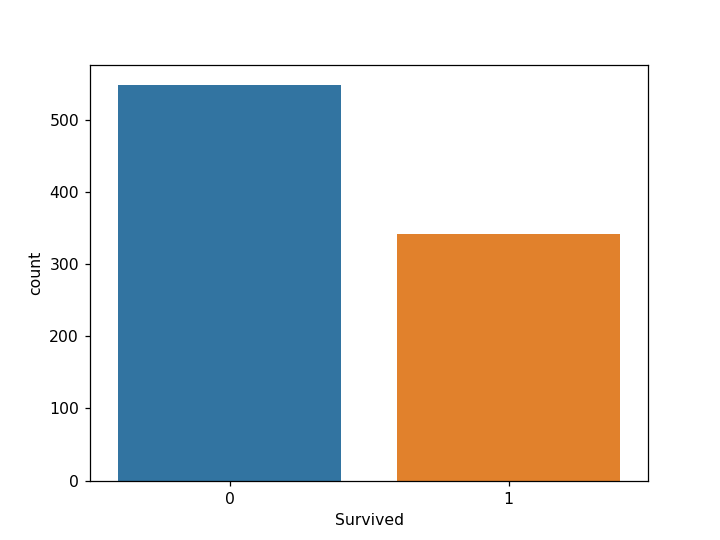

In [15]:
sns.countplot('Survived',data=data)

<IPython.core.display.Javascript object>


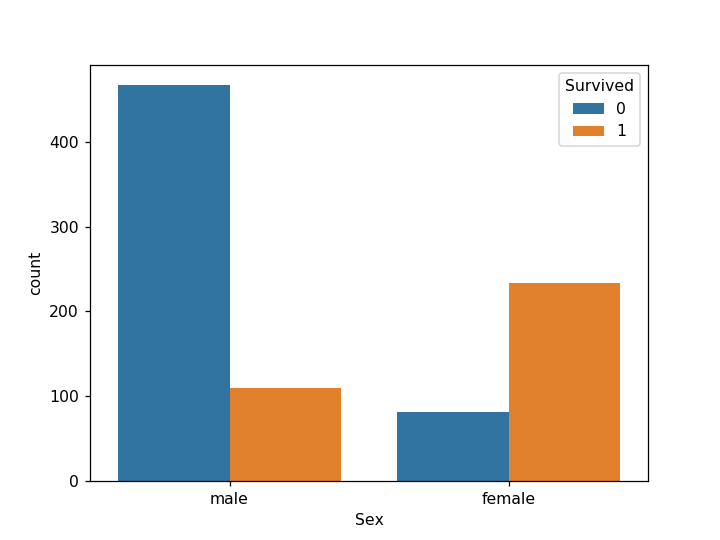

In [16]:
#Нека видим набързо и колко хора са оцелели спрямо пола.
sns.countplot('Sex',hue='Survived',data=data)

Съвсем нормално по-голяма част от оцелелите са жени.

Сега ще съпоставим всеки възможен Feature с Survived за да видим с какви данни си имаме работа.

<IPython.core.display.Javascript object>


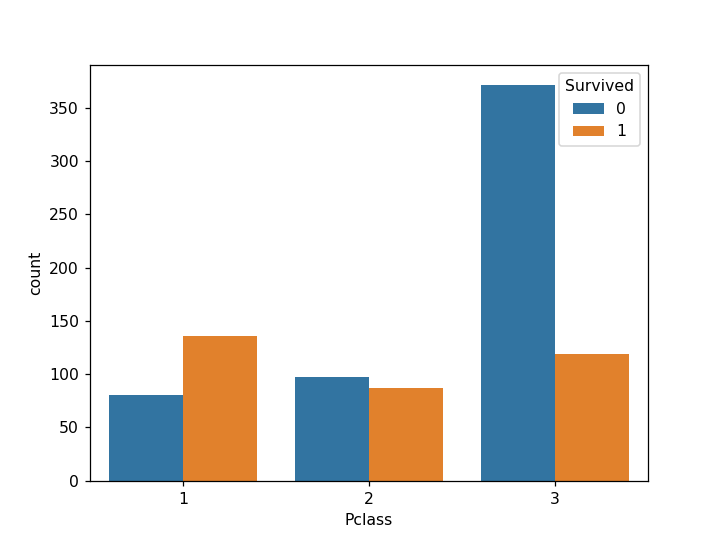

In [17]:
#Pclass vs. Survived
sns.countplot('Pclass',hue='Survived',data=data)

<IPython.core.display.Javascript object>


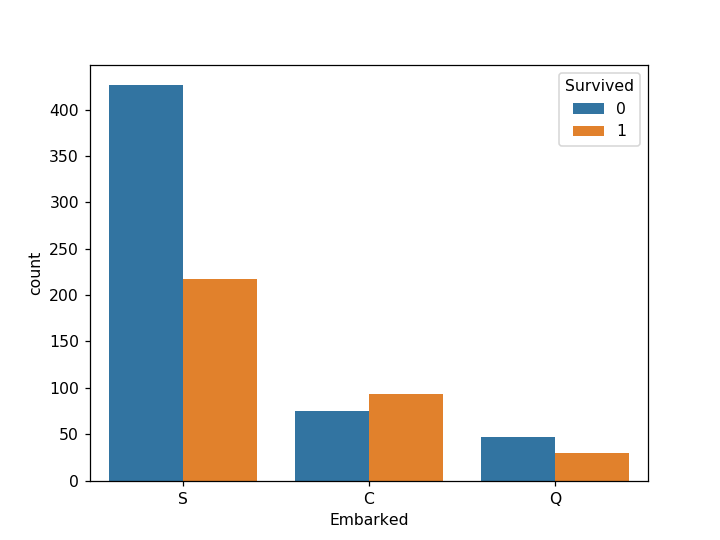

In [18]:
#Embarked vs. Survived
sns.countplot('Embarked',hue='Survived',data=data)

In [19]:
#Понеже са само 2 празни можем да попълним с най-популярния.
data.Embarked = data.Embarked.fillna('S')
data.Embarked.isnull().any()

False

Изводи:
    1. 3та класа не е за предпочитане ако ти се живее
    2. Ако си се качил в Southampton не е много добре за теб.
    3. Хората, без семество, и тези с прекалено големи семейства нямат много щастливо бъдеще според данните.
    4. Полът е много определящ за оцеляването.

Нека разгледаме зависимостите между feature-ите

<IPython.core.display.Javascript object>


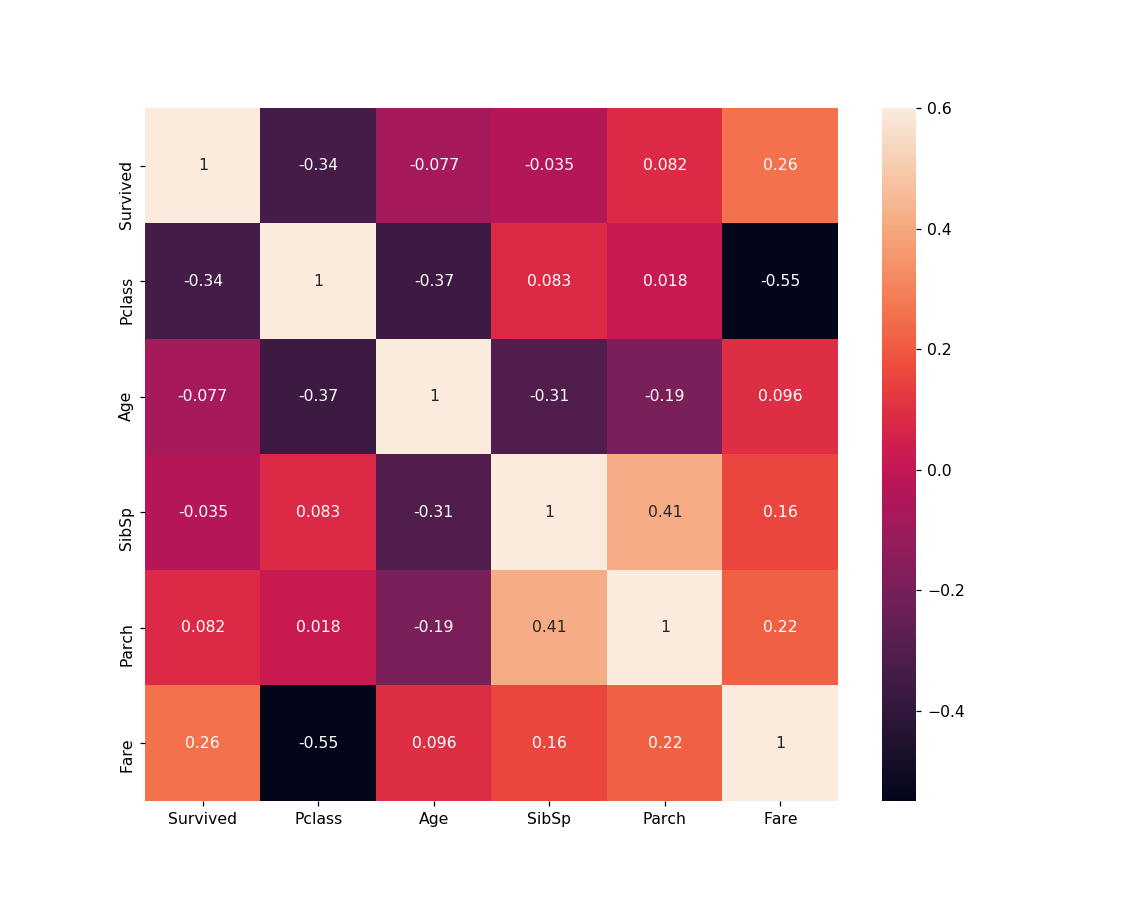

In [20]:
plt.figure(figsize=(10,8))
foo = sns.heatmap(data.corr(), vmax=0.6, square=True, annot=True)


Общо взето потвърдихме вече възникналите наблюдения, но сега поне можем да сме сигурни в предположинията си.
Можем да видим, че някой от нашите Feature-и имат доста малък Impact, но с малко работа това може би ще се промени.

# Feature Enginearing

In [21]:
data[['Name']].head(10)

,Name
PassengerId,
1,"Braund, Mr. Owen Harris"
2,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
3,"Heikkinen, Miss. Laina"
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
5,"Allen, Mr. William Henry"
6,"Moran, Mr. James"
7,"McCarthy, Mr. Timothy J"
8,"Palsson, Master. Gosta Leonard"
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"


Забелязваме, че в имената на хората се съдържат титли. Те биха могли да ни помогнат попълването на възрастта. Затова нека ги отделим.

In [22]:
data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
data.loc[data.Title == 'Mlle', 'Title'] = 'Miss'
data.loc[data.Title == 'Mme', 'Title']  = 'Mrs'
data.loc[data.Title == 'Ms', 'Title']   = 'Miss'
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir']
data.Title = data.Title.replace(rare_titles, 'Rare')
data.Title.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

Нека направим един бърз Encode за да можем по-късно да направим малка магия за попълване на празните Agе. 

In [23]:

encoded = data.copy()
encoded['Male'] = (encoded.Sex == 'male').astype(float)
encoded['Female'] = (encoded.Sex == 'female').astype(float)
encoded['IsMr']      = (encoded.Title == 'Mr').astype(float)
encoded['IsMiss']    = (encoded.Title == 'Miss').astype(float)
encoded['IsMrs']     = (encoded.Title == 'Mrs').astype(float)
encoded['IsMaster']  = (encoded.Title == 'Master').astype(float)
encoded['IsRare']    = (encoded.Title == 'Rare').astype(float)
encoded['EmbarkedC'] = (encoded.Embarked == 'C').astype(float)
encoded['EmbarkedQ'] = (encoded.Embarked == 'Q').astype(float)
encoded['EmbarkedS'] = (encoded.Embarked == 'S').astype(float)

encoded = encoded.drop(['Name','Sex', 'Embarked', 'Title'], axis=1)
encoded.head(15)

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Male,Female,IsMr,IsMiss,IsMrs,IsMaster,IsRare,EmbarkedC,EmbarkedQ,EmbarkedS
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,A/5 21171,7.2500,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,1,38.0,1,0,PC 17599,71.2833,C85,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,1,35.0,1,0,113803,53.1000,C123,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5,0,3,35.0,0,0,373450,8.0500,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0,3,NaN,0,0,330877,8.4583,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0,1,54.0,0,0,17463,51.8625,E46,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0,3,2.0,3,1,349909,21.0750,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,1,3,27.0,0,2,347742,11.1333,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Сега следва да се справим с празните стойности. Cabin има прекалено много празни затова е хубаво да я изхвърлим, но нека опитаме да помислим. Знаем, че има много празни стойности в Cabin. Защо? Ако си пропомним филма можем да видим, че повечето от хората от 3та класа празнуваха в нещо като обща стая. Тоест предполагаме, че по-ниската класа билет не осигурява отделна стая. Идеята е проста- нека създадем нов feature hasCabin. Тя ще показва дали даденият човек има кабина. Null стойностите ще запълним с нули, а всичко останало с 1.

In [24]:
encoded['hasCabin'] = (encoded.Cabin == encoded.Cabin).astype(float)
encoded = encoded.drop('Cabin',axis=1)
encoded['hasCabin'].head(10)


PassengerId
1     0.0
2     1.0
3     0.0
4     1.0
5     0.0
6     0.0
7     1.0
8     0.0
9     0.0
10    0.0
Name: hasCabin, dtype: float64

<IPython.core.display.Javascript object>


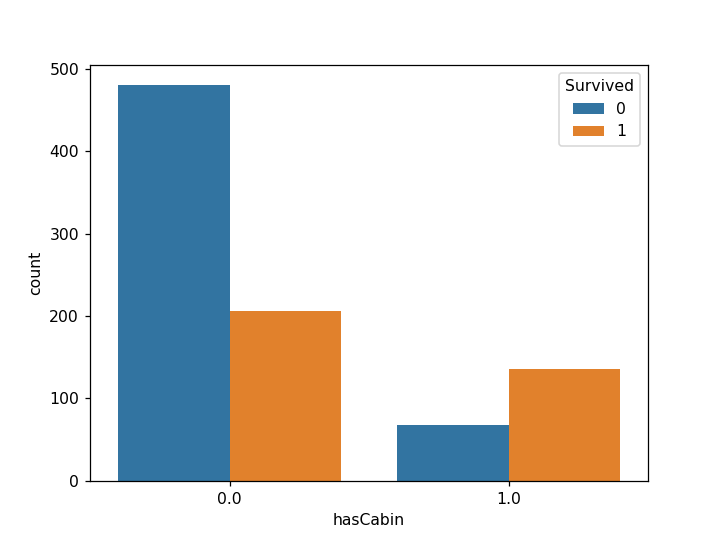

In [25]:
#hasCabin vs. Survived
sns.countplot('hasCabin', hue='Survived',data=encoded)

Забелязваме, че хората, които имат кабини имат по-голяма вероятност да оцелеят. Нека сега да видим как ще 
изглеждат данните за съпоставката hasCabin vs. Pclass.

<IPython.core.display.Javascript object>


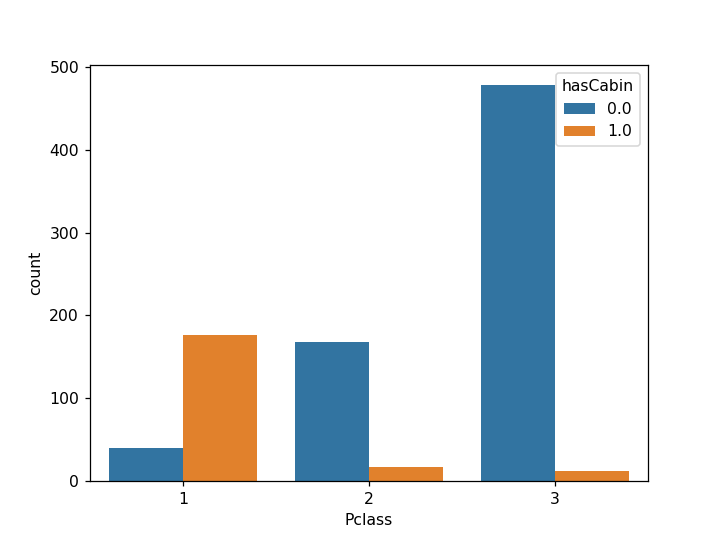

In [26]:
#hasCabin vs. Pclass
sns.countplot('Pclass', hue='hasCabin',data=encoded)

Очевидно хората без кабина са главно от 3та и 2ра класа. Знаем, че ако нямаш кабина има вероятност да не оцелееш, но
също знаем, че ако си от 2ра или 3та класа имаш по-малък шанс да оцелееш. Може би тук има нещо интересно. Можем да 
задълбочим теза разсъждения ако хубаво разгледаме номерата на кабините за тези, които имат такива. Така най-вероятно 
ще стигнем до извода, че всички от 1ва и 2ра класа имат кабини, а повечето от 3та класа са заедно в 1 "кабина".

Относто Age, вместо да запълваме с нули, средни стойности или да използваме титли ще опитаме да предскажем
стойностите с RandomForestRegressor.

In [27]:
from sklearn.ensemble import RandomForestRegressor
def fill_null_age(data):

    age_data = data.drop(['Ticket','Survived'],axis=1)
    
    train  = age_data.loc[(data.Age.notnull())]
    test = age_data.loc[(data.Age.isnull())]
    y = train['Age']
    X = train.drop('Age',axis=1)
    
    random_regr = RandomForestRegressor(n_estimators=1000)
    random_regr.fit(X,y)
    
    predicted_ages = random_regr.predict(test.drop('Age',axis=1))

    data.loc[data.Age.isnull(),'Age'] = predicted_ages.astype(int)
    return data

In [28]:
encoded_age_filled = fill_null_age(encoded)
encoded_age_filled.head(15)

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Male,Female,IsMr,IsMiss,IsMrs,IsMaster,IsRare,EmbarkedC,EmbarkedQ,EmbarkedS,hasCabin
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,A/5 21171,7.2500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,38.0,1,0,PC 17599,71.2833,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,35.0,1,0,113803,53.1000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
5,0,3,35.0,0,0,373450,8.0500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0,3,39.0,0,0,330877,8.4583,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0,1,54.0,0,0,17463,51.8625,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,0,3,2.0,3,1,349909,21.0750,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,1,3,27.0,0,2,347742,11.1333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<IPython.core.display.Javascript object>


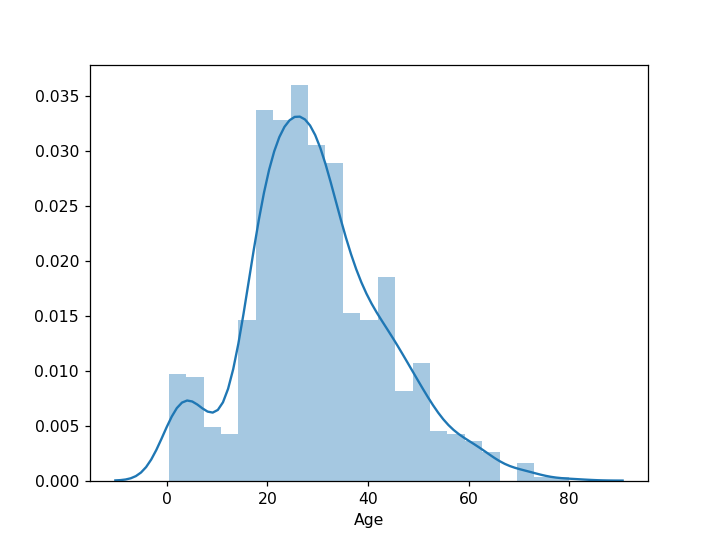

c:\users\dimiter\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [29]:
sns.distplot(encoded_age_filled.Age);

Тази графика изглежа доста добре, т.е. най-вероятно не сме направили грешка като предсказахме празните клетки от Age.

## Fit all models and pray you get decent results

Започваме с логистична регресия, след това ще минем през RandomForestClassifier и ще погледнем техните confusion_matrix
и report.

In [30]:
#Split that data like its nothing
data_final = encoded_age_filled.drop('Ticket',axis=1)
x = data_final.drop('Survived',axis=1)
y = data_final['Survived']

from sklearn.model_selection import train_test_split
x_train, x_test , y_train, y_test = train_test_split(x, y, random_state = 3, stratify=y)
data_final.head(1)

,Survived,Pclass,Age,SibSp,Parch,Fare,Male,Female,IsMr,IsMiss,IsMrs,IsMaster,IsRare,EmbarkedC,EmbarkedQ,EmbarkedS,hasCabin
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.25,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression().fit(x_train, y_train)
print("train:",logistic.score(x_train, y_train))
print("test:", logistic.score(x_test, y_test))

train: 0.8203592814371258
test: 0.8923766816143498


Резултатът не е лош, виждаме че генерализира добре. Нека си погледнем теглата на feature-ите набързо и да пробваме друг класификатор след това.

In [32]:
def logistic_regression_features(X, model):
    plt.figure(figsize=(10,6))
    barplot = sns.barplot(x=X.columns, y=model.coef_[0], orient='vertical')
    plt.setp(barplot.get_xticklabels(), rotation=90)
    plt.grid(True)

<IPython.core.display.Javascript object>


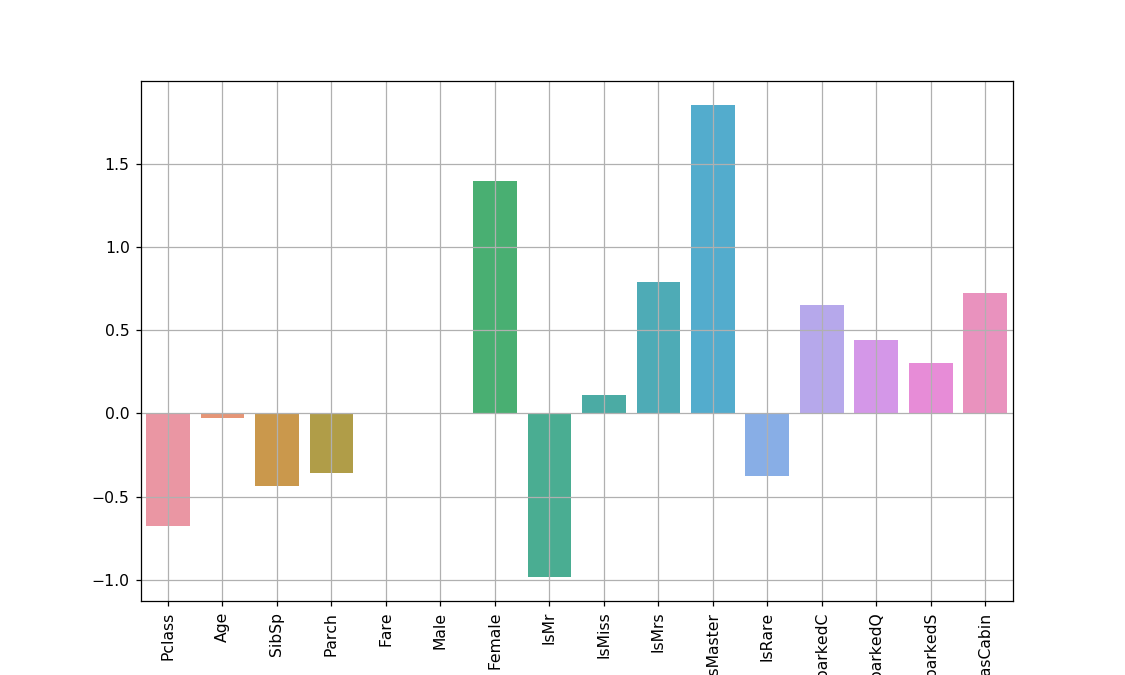

In [33]:
logistic_regression_features(x, logistic)

Нека си encode-нем Pclass

In [34]:
#data_final['Class1'] = (data_final.Pclass == 1).astype(float)
#data_final['Class2'] = (data_final.Pclass == 2).astype(float)
#data_final['Class3'] = (data_final.Pclass == 3).astype(float)
#data_final = data_final.drop('Pclass', axis=1)
data_final.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Male,Female,IsMr,IsMiss,IsMrs,IsMaster,IsRare,EmbarkedC,EmbarkedQ,EmbarkedS,hasCabin
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,38.0,1,0,71.2833,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,3,26.0,0,0,7.9250,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,35.0,1,0,53.1000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
5,0,3,35.0,0,0,8.0500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Друг алгоритъм за класификация е SVM(Support Vector Machine)

### Ще пробваме няколко негови варианта:

#### Линеен SVM

In [35]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC().fit(x_train,y_train)
print("SVM Train:",linear_svm.score(x_train,y_train))
print("SVM Test:",linear_svm.score(x_test,y_test))

SVM Train: 0.811377245508982
SVM Test: 0.8699551569506726


#### Gaussian Kernel

In [36]:
from sklearn.svm import SVC

gaussian_svm = SVC().fit(x_train,y_train)
print("SVM Train:",gaussian_svm.score(x_train,y_train))
print("SVM Test:",gaussian_svm.score(x_test,y_test))

SVM Train: 0.8862275449101796
SVM Test: 0.8161434977578476


In [37]:
#Тук можем да си поиграем с хиперпараметрите
gaussian_svm = SVC(C=5000,gamma=0.0009).fit(x_train,y_train)
print("SVM Train:",gaussian_svm.score(x_train,y_train))
print("SVM Test:",gaussian_svm.score(x_test,y_test))

SVM Train: 0.8802395209580839
SVM Test: 0.8789237668161435


### 87% не са зле!

## Следва да пробваме SGD(Stochastic Gradient Descent)

In [38]:
from sklearn.linear_model import SGDClassifier

SGD = SGDClassifier().fit(x_train,y_train)
print("SGD Train:",SGD.score(x_train,y_train))
print("SGD Test:",SGD.score(x_test,y_test))

SGD Train: 0.7125748502994012
SGD Test: 0.7533632286995515


c:\users\dimiter\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


### Абсолютно трагедия :D Продължаваме напред

# Сега нека видим как ще се справи DecisionTree

In [39]:
from sklearn.tree import DecisionTreeClassifier

#Без сетване на хиперпараметри
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
y_train_pred = decision_tree.score(x_train,y_train)
y_test_pred = decision_tree.score(x_test,y_test)
print("DecisionTree results:")
print("  Train:",y_train_pred)
print("  Test:",y_test_pred)

DecisionTree results:
  Train: 0.9880239520958084
  Test: 0.874439461883408


### Виждаме ГИГАНТСКИ overfit. Какво следва? GridSearch очевидно.

In [41]:
from sklearn.model_selection import GridSearchCV

dt_search = GridSearchCV(decision_tree, {'max_depth': range(1,10),
                                    'max_features':  range(1,x_train.shape[1]),
                                    'min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True),
                                    "criterion": ["gini", "entropy"]}
                                    ,return_train_score="True")
dt_search.fit(x_train, y_train)

pd.DataFrame(dt_search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_test_score,params
1010,1,0.820359,"{'min_samples_split': 0.1, 'max_depth': 7, 'cr..."
840,2,0.815868,"{'min_samples_split': 0.1, 'max_depth': 6, 'cr..."
1930,3,0.814371,"{'min_samples_split': 0.1, 'max_depth': 4, 'cr..."
2090,3,0.814371,"{'min_samples_split': 0.1, 'max_depth': 5, 'cr..."
1940,3,0.814371,"{'min_samples_split': 0.1, 'max_depth': 4, 'cr..."


### След над час прекаран в опити с различни параметри и чаканe виждаме че не можем да подобрим резултата върху тест данните :(

Сега ще пробваме RandomForestClassifier. Най-вероятно ще Overfitt-нем отново, но именно за това има GridSearch :) Нека се надяваме,че този път ще помогне

In [42]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(random_state=3).fit(x_train, y_train)
print("train:", rand_forest.score(x_train, y_train))
print("test: ", rand_forest.score(x_test, y_test))

train: 0.9655688622754491
test:  0.8654708520179372


Както се и предполага RandomForest overfitt-ва. Ще направим един бърз GridSearch за да регуляризираме

In [43]:
search = GridSearchCV(rand_forest, {'n_estimators': [100,500,1000,1500],
                              'max_depth': [6, 8, 10],
                                   'max_features': [5,10],
                                   },return_train_score='True')
search.fit(x, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params' ]].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
14,1,0.833895,"{'n_estimators': 1000, 'max_depth': 8, 'max_fe..."
5,2,0.832772,"{'n_estimators': 500, 'max_depth': 6, 'max_fea..."
20,3,0.831650,"{'n_estimators': 100, 'max_depth': 10, 'max_fe..."
15,3,0.831650,"{'n_estimators': 1500, 'max_depth': 8, 'max_fe..."
6,3,0.831650,"{'n_estimators': 1000, 'max_depth': 6, 'max_fe..."
7,3,0.831650,"{'n_estimators': 1500, 'max_depth': 6, 'max_fe..."
18,3,0.831650,"{'n_estimators': 1000, 'max_depth': 10, 'max_f..."
10,3,0.831650,"{'n_estimators': 1000, 'max_depth': 8, 'max_fe..."
4,9,0.830527,"{'n_estimators': 100, 'max_depth': 6, 'max_fea..."
12,9,0.830527,"{'n_estimators': 100, 'max_depth': 8, 'max_fea..."


Тук използвах малко проба-грешка, понеже GridSearch ставаше прекалено тежък за изчакване с повече параметри от тези.

In [44]:
rand_forest = RandomForestClassifier(random_state=3,n_estimators=1500,max_depth=8,
                                     criterion='entropy',max_features=5).fit(x_train, y_train)
print("train:", rand_forest.score(x_train, y_train))
print("test: ", rand_forest.score(x_test, y_test))

train: 0.8982035928143712
test:  0.8878923766816144


In [45]:
def random_forest_features(model, X):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns, rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

Нека видим кои са най-значителните feature-и според RandomForest

<IPython.core.display.Javascript object>


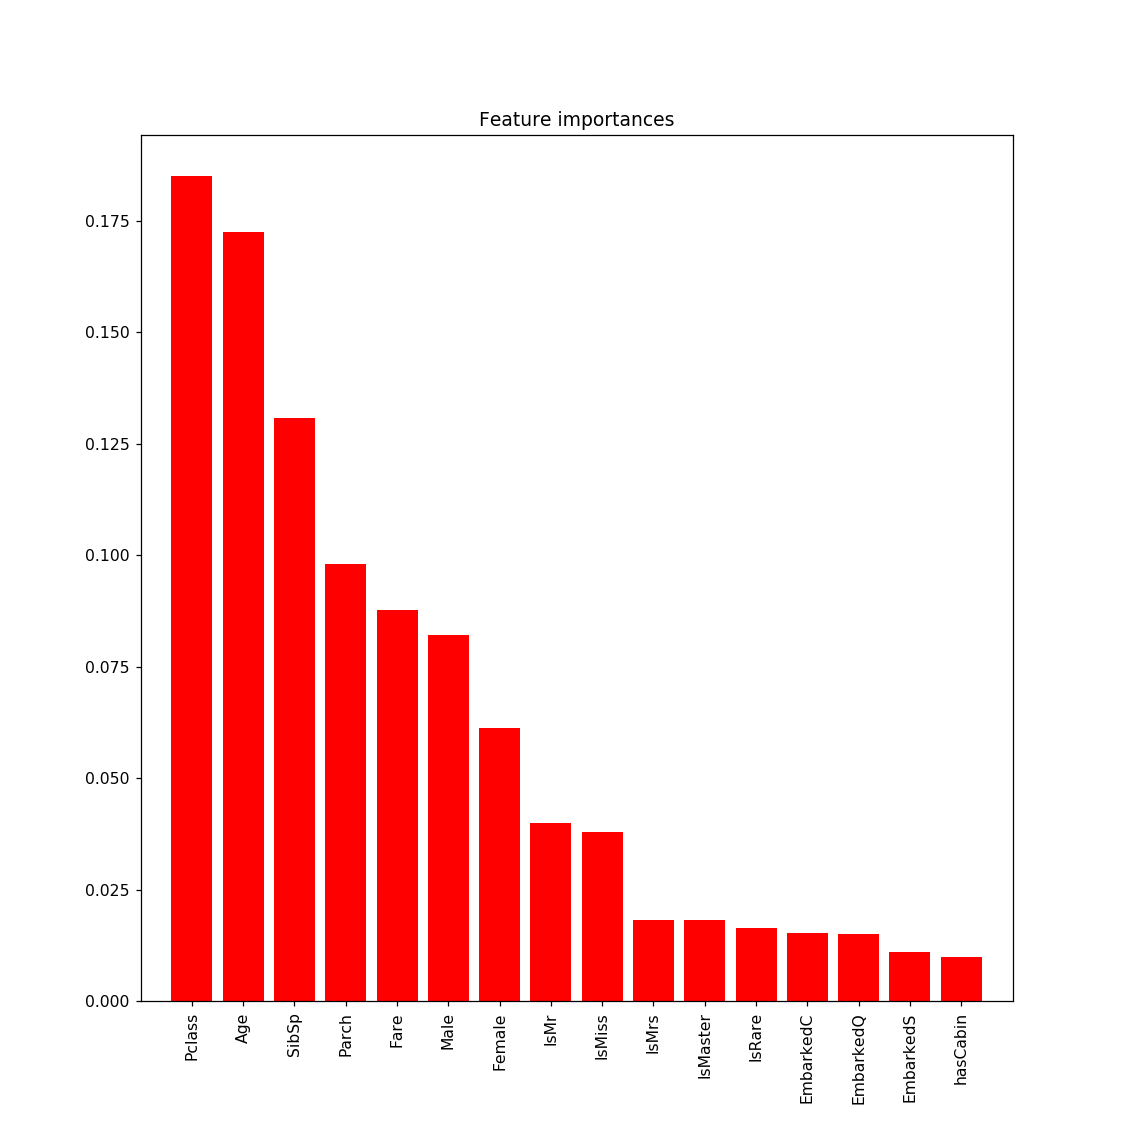

In [46]:
random_forest_features(rand_forest, x_train)

In [49]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(y_test_encoded, rand_forest.predict(x_test_encoded), ['died', 'lived'],normalize = True)

Крайният резултат не е лош, но се видя подобрение след предсказване на годините чрез RandomForest.
Създаването на hasCabin не помогна много за точността, дори се оказа, че е най-незначителен feature според RandomForest. Може би трябва да се задълбае в номерата на кабините и билетите, тъй като има хора с няколко кабини и едва ли ги ползват само за себе си. 

# Като за финал една малка и лека невронна мрежичка

In [191]:
from sklearn.neural_network import MLPClassifier
# MLP = Multi-layer preceptron
NN = MLPClassifier(activation='relu',solver='adam',alpha=1e-3
                   ,hidden_layer_sizes=(1024,16))
NN.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1024, 16), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [192]:
print("train:",NN.score(x_train, y_train))
print("test:",NN.score(x_test, y_test))

train: 0.8038922155688623
test: 0.8340807174887892


# От този резултат се вижда, че невронните мрежи не са универсално решение за всеки проблем. Те работят много добре при картинки и текст!